### Import libraries

In [1]:
from matplotlib import pyplot as plt

import numpy as np

from time import time

import seaborn as sns

from iminuit import Minuit

from functools import partial
from numba import njit

from joblib import Parallel, delayed

from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic_2d

from pathlib import Path
import os, sys

SRC_DIR = str(Path('.').resolve().parents[1])
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

import utils

### First Chi2 estimation for window

In [2]:
N = 5
is_highres = False
n_om = N
n_s8 = N
n_gamma = N
n_H0 = N
n_rd = N

H0_min = 50
H0_max = 100
rd_min = 100
rd_max = 200
M_min = -30
M_max = -10

if is_highres:
    om_min = 0.250
    om_max = 0.5
    s8_min = 0.5
    s8_max = 1.05
    gamma_min = 0
    gamma_max = 1.2
    FOLDER = "highres"
else:
    om_min = .05
    om_max = 1
    s8_min = 0.4
    s8_max = 1.2
    gamma_min = -0.5
    gamma_max = 2
    FOLDER = "lowres"

omega_m_vals = np.asarray(np.linspace(om_min, om_max, n_om))
sigma_8_vals = np.asarray(np.linspace(s8_min, s8_max, n_s8))
gamma_vals = np.asarray(np.linspace(gamma_min, gamma_max, n_gamma))

rd_vals = np.asarray(np.linspace(rd_min, rd_max, n_rd))
H0_vals = np.asarray(np.linspace(H0_min, H0_max, n_H0))

min_Om_desy3, max_Om_desy3 = np.min(utils.Om_data_arico), np.max(utils.Om_data_arico)
min_sigma8_desy3, max_sigma8_desy3 = np.min(utils.sigma8_data_arico), np.max(utils.sigma8_data_arico)

X, Y = np.meshgrid(omega_m_vals, sigma_8_vals)
positions = np.vstack([X.ravel(), Y.ravel()])

values = np.vstack([utils.Om_data_arico, utils.sigma8_data_arico])
kde = gaussian_kde(values)
density = kde(positions).reshape(X.shape)

P = density / np.max(density)
with np.errstate(divide='ignore'):
    delta_chi2_grid_desy3 = -2 * np.log(P)
    delta_chi2_grid_desy3[np.isinf(delta_chi2_grid_desy3)] = np.nanmax(delta_chi2_grid_desy3) + 1

@njit
def find_index(x, x_array, delta_x):
    """Find corresponding index for x in an x_array array.

    Args:
        x (float): the x value we have
            Must be between x_array[0] and x_array[-1]
        x_array (numpy array): the array with all values of x
            Must be linspace and sorted
        delta_x (float): the precision of the linspace array

    Returns:
        int: the corresponding index
    """
    return int((x - x_array[0]) / delta_x + 0.5)

@njit
def chi2_rsd_bao_sn1a_wl(omega_m_array, delta_omega_m, sigma_8_array, delta_sigma_8, z_data_rsd, z_data_panth, z_data_bao, fs8_data, fs8_err_plus, fs8_err_minus, dmrd_data, dmrd_err, n_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, c, chi2_desy3_grid, omega_m, sigma_8, gamma, rd, H0, M):
    i_omega = find_index(omega_m, omega_m_array, delta_omega_m)
    i_sigma = find_index(sigma_8, sigma_8_array, delta_sigma_8)
    # return utils.chi2_rsd(z_data_rsd, fs8_data, fs8_err_plus, fs8_err_minus, omega, sigma, gamma) + utils.chi2_panth(n_panth, z_data_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, omega, H0, M, c)
    # return utils.chi2_rsd(z_data_rsd, fs8_data, fs8_err_plus, fs8_err_minus, omega, sigma, gamma) + utils.chi2_bao_dmrd(z_data_bao, dmrd_data, dmrd_err, c, omega, rd, H0)
    # return chi2_desy3_grid[i_sigma, i_omega]
    return utils.chi2_functions.chi2_rsd(z_data_rsd, fs8_data, fs8_err_plus, fs8_err_minus, omega_m, sigma_8, gamma) + utils.chi2_functions.chi2_bao_dmrd(z_data_bao, dmrd_data, dmrd_err, c, omega_m, rd, H0) + utils.chi2_functions.chi2_panth(n_panth, z_data_panth, is_calibrator_panth, m_b_corr_panth, ceph_dist_panth, inv_cov_panth, omega_m, H0, M, c) + chi2_desy3_grid[i_omega, i_sigma]

### Defining parameters
delta_omega_m = omega_m_vals[1] - omega_m_vals[0]
delta_sigma_8 = sigma_8_vals[1] - sigma_8_vals[0]

delta_chi2_grid_desy3 = np.asarray(delta_chi2_grid_desy3)

chi2_func = partial(
    chi2_rsd_bao_sn1a_wl,
    omega_m_vals,
    delta_omega_m,
    sigma_8_vals,
    delta_sigma_8,
    utils.z_data_rsd,
    utils.z_data_panth,
    utils.z_data_bao,
    utils.fs8_data,
    utils.fs8_err_plus,
    utils.fs8_err_minus,
    utils.Dmrd_data,
    utils.Dmrd_err,
    utils.n_panth,
    utils.is_calibrator_panth,
    utils.m_b_corr_panth,
    utils.ceph_dist_panth,
    utils.inv_cov_panth,
    utils.C,
    delta_chi2_grid_desy3
)

In [4]:
def get_params_used(is_used_list):
      assert len(is_used_list)==6, ValueError(
            f"Expected a 6 booleans for the used parameters, got {len(is_used_list)}.")
      params_used = []
      return [["omega_m", is_used_list[0], (om_min, om_max)],
                  ["sigma_8", is_used_list[1], (s8_min, s8_max)],
                  ["gamma", is_used_list[2], (gamma_min, gamma_max)],
                  ["M", is_used_list[3], (M_min, M_max)],
                  ["H0", is_used_list[4], (H0_min, H0_max)],
                  ["rd", is_used_list[5], (rd_min, rd_max)]]

params_used = get_params_used([False, False, False, True, False, True])
initial_params = {"omega_m":utils.OMEGAM_0, "sigma_8":utils.SIGMA_8_0, "gamma":utils.GAMMA, "rd":utils.RD, "H0":utils.H0, "M":utils.M}

minimizer = utils.tools.get_minimizer(chi2_func, params_used, initial_params)
result = minimizer.migrad()

utils.tools.display_minimizer(minimizer)
print(result)

Fit results (Chi2 = 1739.450):
omega_m = 0.213 ± 0.007
sigma_8 = 0.703 ± 0.050
gamma = 0.310 ± 0.084
rd = 147.400 ± 1.474
H0 = 74.132 ± 0.169
M = -19.250 ± 0.193
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1739                       │              Nfcn = 123              │
│ EDM = 7.7e-07 (Goal: 0.0002)     │            time = 0.2 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└─

### Calculations

In [ ]:
def chi2_om_s8_func(chi2_func, omega_m, sigma_8, params_used):
    initial_params = {"omega_m":omega_m, "sigma_8":sigma_8, "gamma":utils.GAMMA, "rd":utils.RD, "H0":utils.H0, "M":utils.M}
    minimizer = get_minimizer(chi2_func, params_used, initial_params)
    minimizer.migrad()
    return minimizer.fval

def chi2_om_gamma_func(chi2_func, omega_m, gamma, params_used):
    initial_params = {"omega_m":omega_m, "sigma_8":utils.SIGMA_8_0, "gamma":gamma, "rd":utils.RD, "H0":utils.H0, "M":utils.M}
    minimizer = get_minimizer(chi2_func, params_used, initial_params)
    minimizer.migrad()
    return minimizer.fval

def chi2_s8_gamma_func(chi2_func, sigma_8, gamma, params_used):
    initial_params = {"omega_m":utils.OMEGAM_0, "sigma_8":sigma_8, "gamma":gamma, "rd":utils.RD, "H0":utils.H0, "M":utils.M}
    minimizer = get_minimizer(chi2_func, params_used, initial_params)
    minimizer.migrad()
    return minimizer.fval

t = time()
params_used_om_s8 = get_params_used([True, True, False, False, False, True])
chi2_om_s8 = Parallel(n_jobs=-1)(delayed(chi2_om_s8_func)(chi2_func, omega_m, sigma_8, params_used_om_s8) for sigma_8 in sigma_8_vals for omega_m in omega_m_vals)
chi2_grid1 = np.array(chi2_om_s8).reshape(n_s8, n_om)
t = time() - t
print("chi2_grid 1 calculated in", int(t//60), "min", round(t%60,1), "s.")

# t = time()
# params_used_om_gamma = get_params_used([True, False, True, False, False, True])
# chi2_om_gamma = Parallel(n_jobs=-1)(delayed(chi2_om_gamma_func)(chi2_func, omega_m, gamma, params_used_om_gamma) for omega_m in omega_m_vals for gamma in gamma_vals)
# chi2_grid2 = np.array(chi2_om_gamma).reshape(n_om, n_gamma)
# t = time() - t
# print("chi2_grid 2 calculated in", int(t//60), "min", round(t%60,1), "s.")

# t = time()
# params_used_s8_gamma = get_params_used([False, True, True, False, False, True])
# chi2_s8_gamma = Parallel(n_jobs=-1)(delayed(chi2_s8_gamma_func)(chi2_func, sigma_8, gamma, params_used_s8_gamma) for sigma_8 in sigma_8_vals for gamma in gamma_vals)
# chi2_grid3 = np.array(chi2_s8_gamma).reshape(n_s8, n_gamma)
# t = time() - t
# print("chi2_grid 3 calculated in", int(t  //60), "min", round(t%60,1), "s.")

chi2_grid 1 calculated in 0 min 26.7 s.
chi2_grid 2 calculated in 0 min 11.1 s.
chi2_grid 3 calculated in 0 min 9.6 s.


In [29]:
project_root = Path(__file__).parents[2] if "__file__" in globals() else Path().resolve().parents[2]
output_root = project_root / "output"

utils.tools.save_grid(chi2_grid1, 1, output_root / "4-chi2_RSD_PANTH_DESIDR2_DESY3" / FOLDER)

PosixPath('/home/vicpabo/Documents/Projects/Stage-irap/programs/output')

### Plot

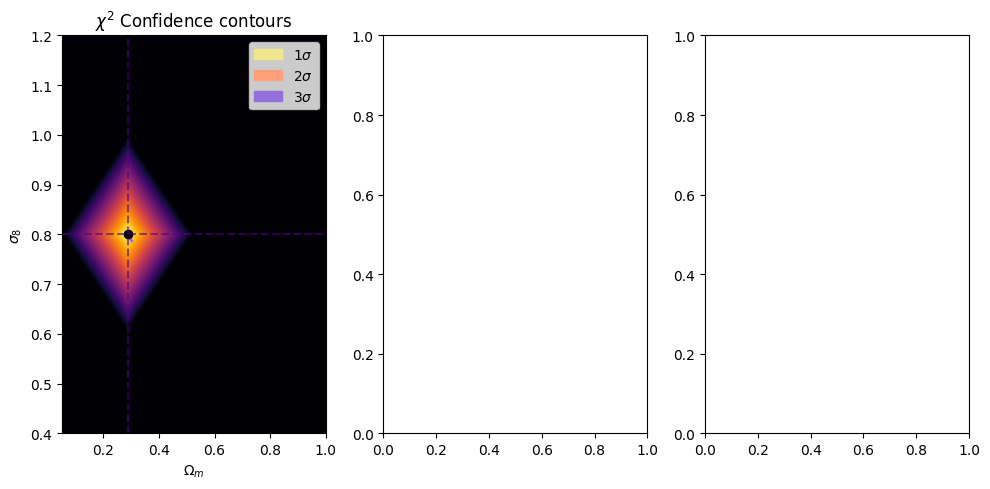

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
utils.tools.plot_chi2_contours(chi2_grid1, omega_m_vals, sigma_8_vals, [r"$\Omega_m$", r"$\sigma_8$"], ax=ax[0])
# utils.tools.plot_chi2_contours(chi2_grid2, gamma_vals, sigma_8_vals, [r"$\gamma$", r"$\sigma_8$"], ax=ax[1])
# utils.tools.plot_chi2_contours(chi2_grid3, gamma_vals, omega_m_vals, [r"$\gamma$", r"$\Omega_m$"], ax=ax[2])